In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('full_df.csv')

In [4]:
df[df['filename'] == '0_right.jpg']

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg


In [5]:
# This is to show that the dataset separate two image files in two rows
df[df['Left-Fundus'] == '4_left.jpg']

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
3197,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",4_left.jpg


In [6]:
# check the string slicing 
x = df['filename']
name = x[0][:-4]
name[-4]

'i'

In [10]:
# test imputing the image
# y = df['filename'][0]
# im = Image.open(f'./0_right_thumbnail.jpg')
# list(im.getdata())

In [8]:
# with open(f'./preprocessed_images/{x}', 'r') as f:
#     print(f)

# The following grabs all the images from the preprocessed_images folder, and create thumbnail to reduce the data size 
from PIL import Image
from tensorflow.keras.preprocessing import image

# create three lists(all, left, right) for the model later
all_images = []
all_images_left = []
all_images_right = []
def get_pixels(values):
    im = Image.open(f'./preprocessed_images/{values}')
    name = values[:-4]
    im.thumbnail((128,128))
    all_images.append(im)
    if name[-5] == 'r':
        all_images_right.append(im)
    else:
        all_images_left.append(im)
    return im

df['pixel_data'] = df['filename'].apply(lambda x: get_pixels(x))

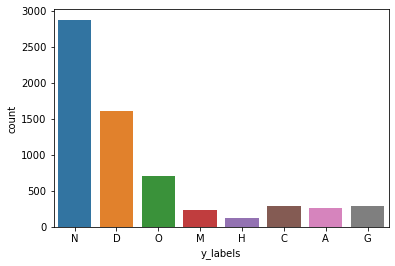

In [14]:
# countplot to show the distribution of the dataset
import seaborn as sns
sns.countplot(df['y_labels'])

In [37]:
df['y_labels'].value_counts()

N    2873
D    1608
O     708
C     293
G     284
A     266
M     232
H     128
Name: y_labels, dtype: int64

In [12]:
df = df.drop('filepath', axis=1)

In [13]:
# create two y labeling methods for different models later on
def y_labels(label):
    return label[2]

def simplify(label):
    if label[2] == 'N':
        return 0
    else:
        return 1

def without_n(label):
    
    
df['y_labels'] = df['labels'].apply(lambda x: y_labels(x))
df['bin_labels'] = df['labels'].apply(lambda x: simplify(x))
df.head(1)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,A,H,M,O,labels,target,filename,pixel_data,y_labels,bin_labels
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,N,0


In [15]:
# check if the data is balanced enough, seems ok in this case
df['bin_labels'].value_counts()

1    3519
0    2873
Name: bin_labels, dtype: int64

In [16]:
# change the image data into array 
for img in range(len(all_images)):
    all_images[img] = image.img_to_array(all_images[img])
    all_images[img] = all_images[img]/255
image_array = np.array(all_images)

In [17]:
image_array.shape

(6392, 128, 128, 3)

In [18]:
for img in range(len(all_images_left)):
    all_images_left[img] = image.img_to_array(all_images_left[img])
for img in range(len(all_images_right)):
    all_images_right[img] = image.img_to_array(all_images_right[img])

In [19]:
image_array_l = np.array(all_images_left)
image_array_r = np.array(all_images_right)

In [20]:
image_array.shape

(6392, 128, 128, 3)

In [54]:
allim = []
for i in range(len(df['filename'])):
    img = image.load_img('./preprocessed_images/'+df['filename'][i],target_size=(100,100))
    img = image.img_to_array(img)
    img = img/255
    allim.append(img)
image_array2 = np.array(allim)
image_array2.shape

(6392, 100, 100, 3)

In [21]:
# find the index number where the left eye image starts
y = df['y_labels'][3194:]
len(y)

3198

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from skimage import io

# x_train = np.array(all_images)
# X_unprocessed = df['pixel_data']
# transformer = ImageDataGenerator(rescale=3.0/255.)
# X = transformer.flow_from_dataframe(df, x_col=X_unprocessed, batch_size=20, target_size=(128,128))
# print(X.shape)
# print(X[0])

y = df['y_labels']

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_y)

binary_y = df['bin_labels']
binary_y = utils.to_categorical(binary_y)

X_train, X_test, y_train, y_test = train_test_split(image_array, dummy_y, test_size=0.25)

In [67]:
dummy_y[0]

array([0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [68]:
print(X_train.shape)
print(y_train.shape)

(4794, 128, 128, 3)
(4794, 8)


## The first model
using softmax as the last activation function, num_classes should be changed when creating different models

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = 8

cnn = Sequential()
cnn.add(Conv2D(25,(3,3),
              activation='relu',
              input_shape=(128,128,3)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Conv2D(50,(3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(num_classes, activation='softmax'))
cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'Precision', 'Recall'])
cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 126, 126, 25)      700       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 25)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 50)        11300     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 50)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 45000)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               5760128   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)              

In [70]:
from tensorflow.keras.utils import plot_model
import pydotplus
import pydot

plot_model(cnn, show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [71]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

### The best accuracy for binary in this model is 55%, for multi-categories is around 46%

In [72]:
batch_size=30
epochs=10

img_rows, img_cols = 28,28


cnn.fit(X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_split=0.2,
       callbacks=[early_stop])

Epoch 1/10
128/128 [==============================] - 21s 163ms/step - loss: 1.6782 - accuracy: 0.4141 - precision: 0.4245 - recall: 0.0777 - val_loss: 1.5767 - val_accuracy: 0.4421 - val_precision: 0.3333 - val_recall: 0.0010
Epoch 2/10
128/128 [==============================] - 20s 155ms/step - loss: 1.6023 - accuracy: 0.4415 - precision: 0.4810 - recall: 0.1022 - val_loss: 1.5541 - val_accuracy: 0.4421 - val_precision: 0.6111 - val_recall: 0.0115
Epoch 3/10
128/128 [==============================] - 21s 161ms/step - loss: 1.5654 - accuracy: 0.4469 - precision: 0.4911 - recall: 0.1153 - val_loss: 1.5427 - val_accuracy: 0.4432 - val_precision: 0.5714 - val_recall: 0.1210
Epoch 4/10
128/128 [==============================] - 22s 170ms/step - loss: 1.5557 - accuracy: 0.4475 - precision: 0.4862 - recall: 0.1153 - val_loss: 1.5392 - val_accuracy: 0.4421 - val_precision: 0.6667 - val_recall: 0.0292
Epoch 5/10
128/128 [==============================] - 21s 165ms/step - loss: 1.5315 - accura

In [86]:
y_predict = cnn.predict(X_test)
y_predict[0:5]

array([[0.02430115, 0.05786459, 0.10312879, 0.21184193, 0.00414914,
        0.02084046, 0.5095545 , 0.06831941],
       [0.05840404, 0.04123365, 0.30181882, 0.03079767, 0.03055104,
        0.01725152, 0.3846001 , 0.13534324],
       [0.03921281, 0.03033204, 0.29216266, 0.03264115, 0.02628312,
        0.01829009, 0.44780064, 0.11327754],
       [0.04805551, 0.04086681, 0.29338983, 0.02723557, 0.02724729,
        0.01001365, 0.42329398, 0.12989745],
       [0.04961231, 0.04542085, 0.26962328, 0.0329733 , 0.02971705,
        0.01101359, 0.43583518, 0.12580438]], dtype=float32)

In [89]:
y_predict = cnn.predict_classes(X_test)
y_predict[0:5]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([6, 6, 6, 6, 6])

In [93]:
y_predict = np.argmax(cnn.predict(X_test), axis=-1)
y_predict[0:5]

array([6, 6, 6, 6, 6])

In [87]:
for i in y_predict:
    for j in range(len(i)):
        if i[j] >= 0.5:
            i[j] = 1
        else:
            i[j] = 0
count=0
for i in range(len(y_predict)):
    flag=True
    for j in range(8):
        if y_predict[i][j] == y_test[i][j]:
            continue
        else:
            flag=False
            break
    if flag:
        count+=1
    
count/len(y_predict)

0.13141426783479349

In [88]:
for i in y_predict:
    for j in range(len(i)):
        if i[j] == max(i):
            i[j] = 1
        else:
            i[j] = 0
count=0
for i in range(len(y_predict)):
    if np.where(y_predict[i] == 1) == np.where(y_test[i] == 1):
        count+=1
count/len(y_predict)

0.16020025031289112

In [129]:
# calculate only for normal eye
y_predict = np.argmax(cnn.predict(X_test), axis=-1)
y_test_arg = np.argmax(y_test, axis=-1)

tp=0
fp=0
tn=0
fn=0
for i in range(len(y_predict)):
    if y_predict[i] == 6:
        if y_test_arg[i] == 6:
            tp+=1
        else:
            fp+=1
    else:
        if y_test_arg[i] == 6:
            fn+=1
        else:
            tn+=1
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f = precision*recall/((precision+recall)*2)
print(precision, recall, f)

0.4560832791151594 0.9831697054698457 0.15577777777777777


In [75]:
score = cnn.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.4555885791778564
Test accuracy: 0.4612014889717102


## The second model
the very first model - using sigmoid as the last activation function, nodes are set to 8 currently

In [120]:
model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='sigmoid'))

from tensorflow.keras.metrics import BinaryAccuracy, CategoricalAccuracy
bin_accu = BinaryAccuracy(dtype=None, threshold=0.5)
cat_accu = CategoricalAccuracy()

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 254016)            0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                16257088  
_________________________________________________________________
dense_40 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_41 (Dense)             (None, 8)                 520       
Total params: 16,263,560
Trainable params: 16,263,560
Non-trainable params: 0
_________________________________________

In [121]:
model.fit(X_train,y_train, epochs=10, batch_size=100)

Epoch 1/10
48/48 [==============================] - 24s 493ms/step - loss: 1.6694 - accuracy: 0.4332
Epoch 2/10
48/48 [==============================] - 23s 481ms/step - loss: 1.5862 - accuracy: 0.4506
Epoch 3/10
48/48 [==============================] - 23s 478ms/step - loss: 1.5727 - accuracy: 0.4506
Epoch 4/10
48/48 [==============================] - 23s 481ms/step - loss: 1.5612 - accuracy: 0.4506
Epoch 5/10
48/48 [==============================] - 24s 495ms/step - loss: 1.5513 - accuracy: 0.4506
Epoch 6/10
48/48 [==============================] - 24s 510ms/step - loss: 1.5451 - accuracy: 0.4506
Epoch 7/10
48/48 [==============================] - 26s 551ms/step - loss: 1.5350 - accuracy: 0.4506
Epoch 8/10
48/48 [==============================] - 24s 492ms/step - loss: 1.5313 - accuracy: 0.4506
Epoch 9/10
48/48 [==============================] - 24s 491ms/step - loss: 1.5211 - accuracy: 0.4506
Epoch 10/10
48/48 [==============================] - 24s 497ms/step - loss: 1.5171 - accura

In [122]:
y_predict = model.predict(X_test)
for i in y_predict:
    for j in range(len(i)):
        if i[j] >= 0.5:
            i[j] = 1
        else:
            i[j] = 0
count=0
for i in range(len(y_predict)):
    flag=True
    for j in range(8):
        if y_predict[i][j] == y_test[i][j]:
            continue
        else:
            flag=False
            break
    if flag:
        count+=1
    
count/len(y_predict)

0.08385481852315395

In [123]:
y_predict = np.argmax(model.predict(X_test), axis=-1)
y_test_arg = np.argmax(y_test, axis=-1)

count=0
for i in range(len(y_predict)):
    if y_predict[i] == y_test_arg[i]:
        count+=1
count/len(y_predict)

0.44618272841051315

In [128]:
# calculate only for normal eye
y_predict = np.argmax(model.predict(X_test), axis=-1)
y_test_arg = np.argmax(y_test, axis=-1)

tp=0
fp=0
tn=0
fn=0
for i in range(len(y_predict)):
    if y_predict[i] == 6:
        if y_test_arg[i] == 6:
            tp+=1
        else:
            fp+=1
    else:
        if y_test_arg[i] == 6:
            fn+=1
        else:
            tn+=1
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f = precision*recall/((precision+recall)*2)
print(precision, recall, f)

0.44618272841051315 1.0 0.15426222414539162


In [125]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.532153844833374
Test accuracy: 0.4461827278137207


## The third model
reference - https://www.kaggle.com/roobansappani/cataract-detection
saw this notebook and it got 93% of accuracy, so I decided to test on the binary case
the model takes a LONG time to fit(check the seconds), I only train for 10 epochs in the following model
### got an accuracy of 63%, could possibly get higher

In [495]:
from tensorflow.keras.applications import VGG19

vgg = VGG19(weights = "imagenet", include_top = False, input_shape=(128, 128, 3))
for layer in vgg.layers:
    layer.trainable = False

model_1 = Sequential()
model_1.add(vgg)
model_1.add(Flatten())
model_1.add(Dense(64, activation = 'relu'))
model_1.add(Dense(2,activation = "softmax"))
model_1.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])

In [497]:
model_1.fit(X_train, y_train, 
            validation_split = 0.2, 
            epochs = 10,
            batch_size = 128)

Epoch 1/10
30/30 [==============================] - 176s 6s/step - loss: 0.6892 - accuracy: 0.5437 - precision: 0.5437 - recall: 0.5437 - val_loss: 0.6793 - val_accuracy: 0.5902 - val_precision: 0.5902 - val_recall: 0.5902
Epoch 2/10
30/30 [==============================] - 176s 6s/step - loss: 0.6716 - accuracy: 0.5739 - precision: 0.5739 - recall: 0.5739 - val_loss: 0.6759 - val_accuracy: 0.5673 - val_precision: 0.5673 - val_recall: 0.5673
Epoch 3/10
30/30 [==============================] - 177s 6s/step - loss: 0.6739 - accuracy: 0.5718 - precision: 0.5718 - recall: 0.5718 - val_loss: 0.6813 - val_accuracy: 0.5485 - val_precision: 0.5485 - val_recall: 0.5485
Epoch 4/10
30/30 [==============================] - 177s 6s/step - loss: 0.6578 - accuracy: 0.5911 - precision: 0.5911 - recall: 0.5911 - val_loss: 0.6924 - val_accuracy: 0.5652 - val_precision: 0.5652 - val_recall: 0.5652
Epoch 5/10
30/30 [==============================] - 176s 6s/step - loss: 0.6514 - accuracy: 0.5958 - precisi

## The try model

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = 8

cnn2 = Sequential()
cnn2.add(Conv2D(25,(3,3),
              activation='relu',
              input_shape=(100,100,3)))
cnn2.add(MaxPooling2D(pool_size=(2,2)))
cnn2.add(Conv2D(50,(3,3), activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2,2)))
cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dropout(0.3))
cnn2.add(Dense(64, activation='relu'))
cnn2.add(Dropout(0.3))
cnn2.add(Dense(num_classes, activation='softmax'))
cnn2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'Precision', 'Recall'])

In [59]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [61]:
batch_size=30
epochs=10

img_rows, img_cols = 28,28


cnn2.fit(X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_split=0.2,
       callbacks=[early_stop])

Epoch 1/10
128/128 [==============================] - 13s 105ms/step - loss: 1.6391 - accuracy: 0.4360 - precision: 0.4606 - recall: 0.0975 - val_loss: 1.5869 - val_accuracy: 0.4432 - val_precision: 0.3750 - val_recall: 0.0031
Epoch 2/10
128/128 [==============================] - 14s 107ms/step - loss: 1.5741 - accuracy: 0.4506 - precision: 0.4883 - recall: 0.1199 - val_loss: 1.5452 - val_accuracy: 0.4432 - val_precision: 0.6000 - val_recall: 0.0282
Epoch 3/10
128/128 [==============================] - 13s 103ms/step - loss: 1.5523 - accuracy: 0.4579 - precision: 0.4900 - recall: 0.1150 - val_loss: 1.5254 - val_accuracy: 0.4463 - val_precision: 0.6618 - val_recall: 0.0469
Epoch 4/10
128/128 [==============================] - 13s 105ms/step - loss: 1.5355 - accuracy: 0.4540 - precision: 0.5167 - recall: 0.1452 - val_loss: 1.5162 - val_accuracy: 0.4463 - val_precision: 0.6809 - val_recall: 0.0334
Epoch 5/10
128/128 [==============================] - 14s 106ms/step - loss: 1.5094 - accura

In [63]:
score = cnn2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.4350862503051758
Test accuracy: 0.4524405598640442


In [11]:
df_excel = pd.read_excel('./ODIR-5K/ODIR-5K/data.xlsx', sheet_name='Sheet1')

In [98]:
df_excel

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
